In [2]:
import os

import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
f = gzip.GzipFile(r"../../Data/rBergomiTrainSet.txt.gz", "r")
dat=np.load(f)
xx=dat[:,:4]
yy=dat[:,4:]
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


x_train, x_test, y_train, y_test = train_test_split(
    xx, yy, test_size=0.15, random_state=42)

In [3]:
def append_and_expand(a,x,y):
    # use choose and where !
    n = len(x)*len(y)
    a_index = np.arange(len(a))%n
    
    
    x_index = a_index//len(y)
    y_index = a_index%len(y)
    
    x_added = np.choose(x_index,x.reshape(-1,1)).reshape(-1,1)
    y_added = np.choose(y_index,y.reshape(-1,1)).reshape(-1,1)
    
    return np.hstack([a,x_added,y_added])

y_train,y_test = y_train.reshape(-1,8,11),y_test.reshape(-1,8,11)
x_train,x_test = np.repeat(x_train, 8*11,axis=0),np.repeat(x_test, 8*11,axis=0)

x_train,x_test=append_and_expand(x_train,maturities,strikes),append_and_expand(x_test,maturities,strikes)
y_train,y_test = y_train.reshape(-1).reshape(-1,1), y_test.reshape(-1).reshape(-1,1)

In [5]:
import torch
import torch.nn as nn

scale_y=  StandardScaler()

def ytransform(y_train,y_test):
    return [scale_y.fit_transform(y_train),scale_y.transform(y_test)]

def yinversetransform(y):
    return scale_y.inverse_transform(y)

# Upper and lower bounds used in the training set
ub=np.array([0.16,4,-0.1,0.5,2.0,1.5])
lb=np.array([0.01,0.3,-0.95,0.025,0.1,0.5])

def myscale(x):
    return (x - (ub+lb)*0.5)*2/(ub-lb)
def myinverse(x):
    return x*(ub-lb)*0.5+(ub+lb)*0.5

x_train_transform = myscale(x_train)
x_test_transform = myscale(x_test)
[y_train_transform,y_test_transform] = ytransform(y_train,y_test)

device = torch.device('cpu')
print(f"device is {device}")

test_sample_nums = 528000

theta_transform = x_test_transform[:test_sample_nums,:4]
T_K_transform = x_test_transform[:test_sample_nums,4:]
y_test_transform = y_test_transform[:test_sample_nums]

# Upper and lower bounds used in the training set
ub_theta=ub[:4]
lb_theta=lb[:4]

def mythetascale(x):
    return (x - (ub_theta+lb_theta)*0.5)*2/(ub_theta-lb_theta)
def mythetainverse(x):
    return x*(ub_theta-lb_theta)*0.5+(ub_theta+lb_theta)*0.5

device is cpu


In [6]:
import numpy as np
import pandas as pd
import torch 
import scipy
import time

import sys
sys.path.append('../../')  # Add the parent directory to the Python path

from torch_NN.nn import ResNN_pricing

device = torch.device('cpu')
tensor_dtype = torch.float64

# Set the derivatives dynamic model's parameter's nums here !
Paranums = 4

hyperparas = {'input_dim':6,'hidden_dim':64,'hidden_nums':10,'output_dim':1,'block_layer_nums':3}

model = ResNN_pricing(hyperparas=hyperparas).to(device=device,dtype=tensor_dtype)

model_state = torch.load('../../Data/YU/rflatBergomi_pointwise88.pth')

model.load_state_dict(model_state)

model.eval()


model.to(device=device,dtype=tensor_dtype)

ResNN_pricing(
  (linear_stock): Sequential(
    (0): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): ReLU()
    )
    (1): ResNetBlock(
      (layers): ModuleList(
        (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
      )
      (layernorms): ModuleList(
        (0-1): 2 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (2): ResNetBlock(
      (layers): ModuleList(
        (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
      )
      (layernorms): ModuleList(
        (0-1): 2 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (3): ResNetBlock(
      (layers): ModuleList(
        (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
      )
      (layernorms): ModuleList(
        (0-1): 2 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (4): ResNetBlock(
      (layers): ModuleList(
        (0-1): 2 x Linear(in_features=64, out_features=64, bi

[ 0.0553513  1.32461   -0.418079   0.48201  ]


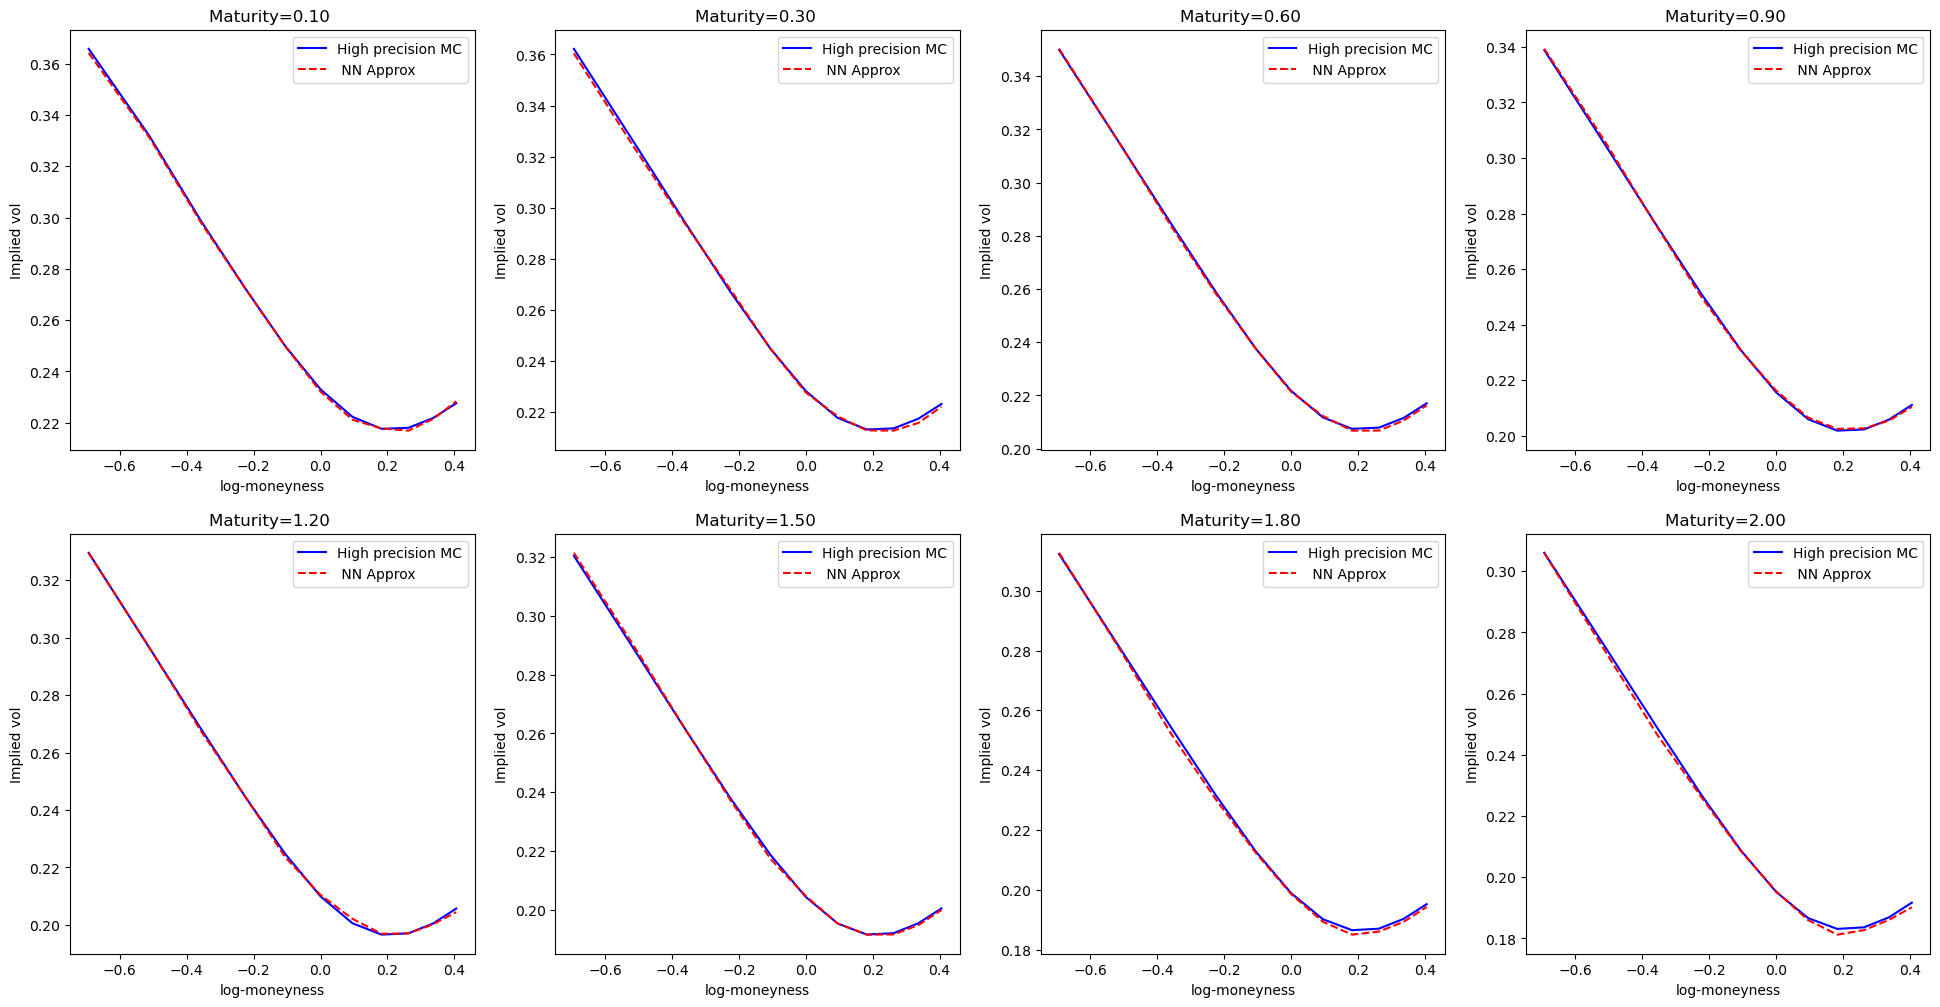

In [57]:
sample_id = 120

sample_model_input = x_test_transform[sample_id*88:(sample_id+1)*88,:]
sample_theta = myinverse(x_test_transform[sample_id*88,:])[:4]
sample_TK = myinverse(x_test_transform[sample_id*88:(sample_id+1)*88,:])[:,4:]

print(sample_theta)

vol_model = yinversetransform(model(torch.from_numpy(sample_model_input)).detach().numpy())
vol_real = yinversetransform(y_test_transform[sample_id*88:(sample_id+1)*88,:])

vol_model = vol_model.reshape(-1)
vol_real = vol_real.reshape(-1)

plt.figure(1,figsize=(24,12))
for i in range(8):
    plt.subplot(2,4,i+1)
    
    plt.plot(np.log(strikes),vol_real[i*11:(i+1)*11],'b',label="High precision MC")
    plt.plot(np.log(strikes),vol_model[i*11:(i+1)*11],'--r',label=" NN Approx")

    
    plt.title("Maturity=%1.2f "%maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()

plt.show()

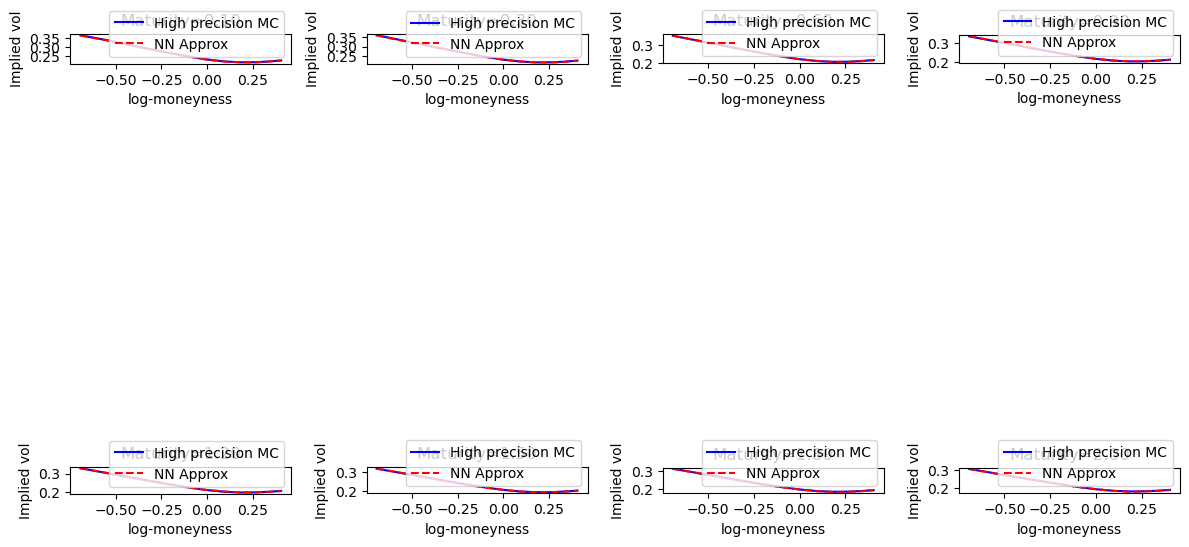

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming necessary transformations and data are already defined
# sample_id, x_test_transform, myinverse, yinversetransform, model, y_test_transform, strikes, maturities

sample_id = 120

sample_model_input = x_test_transform[sample_id*88:(sample_id+1)*88, :]
sample_theta = myinverse(x_test_transform[sample_id*88, :])[:4]
sample_TK = myinverse(x_test_transform[sample_id*88:(sample_id+1)*88, :])[:, 4:]

vol_model = yinversetransform(model(torch.from_numpy(sample_model_input)).detach().numpy())
vol_real = yinversetransform(y_test_transform[sample_id*88:(sample_id+1)*88, :])

vol_model = vol_model.reshape(-1)
vol_real = vol_real.reshape(-1)

# Adjusting the figure size and subplot aspect ratio
plt.figure(figsize=(12, 12))
for i in range(8):
    plt.subplot(2, 4, i+1, aspect='equal')
    
    plt.plot(np.log(strikes), vol_real[i*11:(i+1)*11], 'b', label="High precision MC")
    plt.plot(np.log(strikes), vol_model[i*11:(i+1)*11], '--r', label="NN Approx")

    plt.title(f"Maturity={maturities[i]:1.2f}")
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()

plt.tight_layout()
plt.show()
